# Computational Design of Microbial Communities - part 3

You will have seen in the last part that, using the ABC rejection algorithm, we can produce an approximation of the parameter posterior distributions for the gLV model to acheive a desired behaviour (in our case, stable co-existence at desired population levels).

You should also have noticed that, for the priors and acceptance threshold that we used, we had to sample, simulate, and reject ~800 particles for every particle that we accepted - and our acceptance threshold was not particularly stringent. There is no rule for how many accepted particles one needs for a good posterior approximation, but in general we would aim for >10,000, requiring ~1e7 simulations.


## Approximate Bayesian Computation Sequential Monte Carlo (ABC SMC)

In place of the simple rejection algorithm, we can use a sequential Monte Carlo (SMC) sampling to reduce the computational expense. This method works by starting with a lenient acceptance threshold and incrementally reducing it until we reach the desired threshold. The posterior distribution from the the previous threshold forms the prior distribution for the next threshold. In this way, we sequentially refine the sample space for each parameter based on current best evidence and maintain a high particle acceptance rate.

Here we will use the ABC SMC implementation in the pyABC package, but to really understand the intricacies of the algorithm it is well worth implementing it yourself.

The algorithm differs in a few places from ABC rejection

1. Set initial threshold and desired final threshold
2. For the initial threshold use the ABC rejection algorithm to get a starting population
3. Adjust the acceptance threshold (usually based on the distances in the previous population)
4. Sample *weighted* particle from the previous population
5. Perturb the particle using a perturbation kernel
6. Simulate the particle and determine whether to accept
7. If we accept the particle, calculate its *weight*
8. If current acceptance threshold is less than or equal to the desired final threshold then we can finish, otherwise go to $3$

There are a few key intricacies here; how do we adjust the threshold after each round, how do we perturb a particle, and what is weighting.

### Adjusting thresholds
There are a few different ways to adjust the threshold, and this is an active area of research. Here we will use the pyABC default method, Median Epsilon strategy which uses the median of the distances from the last population as the epsilon for the next population.

### Perturbing particles
To get a new particle to simulate, we sample a particle from the previous population and then perturb it to get new parameter values. To perform the perturbation we use a kernel which adds random noise to the parameter values. This kernel is usually a Gaussian kernel with variance that is calculated using the parameter variance of the previous population.

### Particle weighting
A particle's weight is the probability of that particle given the previous population of particles. What this means is what is the probability that I sample these parameters given the posterior distribution of the previous population and the perturbation kernel used to perturb sampled particles. The weight of a particle is given by

$$ w^i_t = \frac{\pi(\theta^{**})}{\sum^N_{j=1} w^j_{t-1} K_t(\theta^i_{t-1}|\theta^{**})}


In [1]:
import pyabc
import numpy as np
from scipy.integrate import solve_ivp
from typing import Callable, Union
from IPython.display import clear_output
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Our model class, prior generator, and distance function are the same as previously

In [2]:
class GLVModel:
    """
    Generalized Lotka-Volterra model
    """
    def __init__(self, 
                 num_species: int, 
                 timepoints: np.ndarray, 
                 params: dict = None):
        self.timepoints = timepoints  # Time points for simulation
        self.num_species = num_species  # Number of species in the model
                
        # Set all parameters to 0 if none are provided
        if params is None:
            self.params = {
                "y0": np.zeros(self.num_species),
                "r": np.zeros(self.num_species),
                "A": np.zeros((self.num_species, self.num_species))
            }
        else:
            # if we have y0, r and A, assume we have been given full parameters
            if 'y0' in params.keys() and 'r' in params.keys() and 'A' in params.keys():
                self.params = params
            # otherwise, assume we have been given parameters in the form r_1, A_12 etc, that need reshaping 
            # (this allows us to pass in a subset of parameters to fix)
            else:
                self.params = {
                    'y0': np.zeros(self.num_species),
                    "r": np.zeros(self.num_species),
                    "A": np.zeros((self.num_species, self.num_species))
                }
                self.params = self._reshape_params(params)

    def _step(self, t, y, params):
        """
        Compute the derivatives for the gLV model.
        """ 
        r = params["r"]  # Growth rates (num species,)
        A = params["A"]  # Interaction matrix (num species, num species)
        # y  # Population values (num species,)

        dydt = (r + np.dot(A, y)) * y

        return dydt
    
    def simulate(self, params: dict) -> dict:
        """
        Simulate the model with the given parameters.
        """
        self.params = self._reshape_params(params)

        result = solve_ivp(self._step, 
                           t_span=[0, self.timepoints[-1]], 
                           y0=self.params["y0"], 
                           args=(self.params,), 
                           method='LSODA',  
                           t_eval=self.timepoints,
                           min_step=1e-3
                           )
        
        # Check if integration was successful
        if not result.success:
            return {"success": False}

        # Check for numerical issues
        if np.any(np.isnan(result.y)) or np.any(np.isinf(result.y)):
            return {"success": False}

        return {"success": True, "t": result.t, "y": result.y}

    def _reshape_params(self, params: dict) -> dict:
        """
        Incoming params dictionary has parameters with keys such as 'r_1', 'A_12' etc. This function reshapes them into vectors and matrices as appropriate.
        """
        reshaped_params = self.params.copy()
        for key in params.keys():
            if key.startswith('A_'):
                i, j = map(int, key[2:])
                reshaped_params['A'][i-1, j-1] = params[key]
            else:
                key_base, idx = key.rsplit('_', 1)
                idx = int(idx) - 1
                reshaped_params[key_base][idx] = params[key]

        return reshaped_params


In [3]:
def create_glv_priors(num_species: int = 2) -> dict:
    """
    Create a prior distribution for the gLV model parameters.
    num_species: number of species in the model
    Returns:
        dict: prior distribution for the model parameters
    """
    prior = {}
    for i in range(num_species):
        prior[f'y0_{i+1}'] = {'type': 'uniform', 'args': (0, 2)}  # note the uniform args in scipt.stats are loc and scale, equivalent to min and (max-min)
        prior[f'r_{i+1}'] = {'type': 'uniform', 'args': (-1, 2)}
        for j in range(num_species):
            prior[f'A_{i+1}{j+1}'] = {'type': 'uniform', 'args': (-1, 2)}

    return prior


In [4]:
def distance_function(simulated_data: dict, target_data: dict = None) -> float:
    """
    Compute the aggregated distance between simulated and an objective.
    simulated_data: dict with keys 'success', 't', 'y' from model.simulate()
    target_data: not used here, but could be used to compare to real data or target objectives
    Returns:
        float: distance metric
    """
    
    if simulated_data is None:
        raise ValueError("No simulated data provided")

    # If simulation failed or produced invalid data, return infinite distance
    if simulated_data['success'] is False:
        return np.inf    
    if np.any(simulated_data['y']) < 0:
        return np.inf
    

    distance = 0
    # for each species, calculate distance components
    for i in range(simulated_data['y'].shape[0]):
        # If a species goes extinct, return infinite distance
        final_population = simulated_data['y'][i, -1]
        if final_population <= 0:
            return np.inf
        elif target_data is not None:
            distance += (final_population - target_data['final_population'][i])**2 # squared difference to target final population
        
        # If the population is alive, check that it is stable i.e. minimise final gradient
        gradient = (simulated_data['y'][i, -1] - simulated_data['y'][i, -2]) / (simulated_data['t'][-1] - simulated_data['t'][-2])
        distance += abs(gradient)

    return distance

We create an Acceptor function that is a slight modification of the pyABC default acceptor. This one rejects particles if the distance returned by the distance function is infinite.

In [5]:
# Construct acceptor to reject particles with an infinite distance and use the default acceptor for the rest
class CustomAcceptor(pyabc.UniformAcceptor):
    def __init__(self):
        super().__init__()

    def __call__(self, distance_function, eps, x, x_0, t, par):
        d = distance_function(x, x_0, t, par)
        if np.isinf(d):
            return pyabc.acceptor.AcceptorResult(distance=1e9, accept=False)  # Reject particles with infinite distance
        # Otherwise, use the default acceptor logic
        return super().__call__(distance_function, eps, x, x_0, t, par)

And then we put it all together. The way we run the ABC SMC is very similar, though we first setup a database in which to store results.

In [6]:
# Setup a model
num_species = 2
simulation_timepoints = np.linspace(0, 50, 51)
model = GLVModel(num_species=2, 
                 timepoints=simulation_timepoints
                 )

# Setup prior distributions
prior = create_glv_priors(num_species=num_species)
prior = pyabc.Distribution.from_dictionary_of_dictionaries(prior) # convert to pyabc Distribution

# Setup ABC SMC
abc = pyabc.ABCSMC(models=model.simulate, 
                   parameter_priors=prior, 
                   distance_function=distance_function, 
                   acceptor=CustomAcceptor(),
                   population_size=1000
                   )

db_path = "sqlite:///" + "250923_test.db"
history = abc.new(db_path, observed_sum_stat={"final_population": [3.0, 5.0]})
history = abc.run(minimum_epsilon=1.0)

ABC.History INFO: Start <ABCSMC id=3, start_time=2025-09-23 16:58:47>
ABC INFO: Calibration sample t = -1.
C:\Users\AJFed\AppData\Roaming\Python\Python312\site-packages\scipy\integrate\_ivp\lsoda.py:161: UserWarning: lsoda: Repeated error test failures (internal error).
  solver._y, solver.t = integrator.run(
C:\Users\AJFed\AppData\Roaming\Python\Python312\site-packages\scipy\integrate\_ivp\lsoda.py:161: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  solver._y, solver.t = integrator.run(
ABC INFO: t: 0, eps: inf.
C:\Users\AJFed\AppData\Roaming\Python\Python312\site-packages\scipy\integrate\_ivp\lsoda.py:161: UserWarning: lsoda: Repeated error test failures (internal error).
  solver._y, solver.t = integrator.run(
C:\Users\AJFed\AppData\Roaming\Python\Python312\site-packages\scipy\integrate\_ivp\lsoda.py:161: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  solver._y, solver.t = integrator.run(
ABC INFO:

You can see that the acceptance rate stays reasonably high throughout while the acceptance threshold incrementaly decreases.

<Axes: title={'center': 'Epsilon values'}, xlabel='Population index', ylabel='Epsilon'>

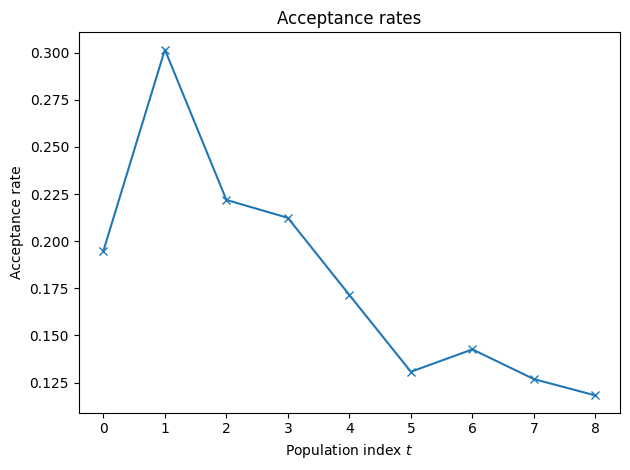

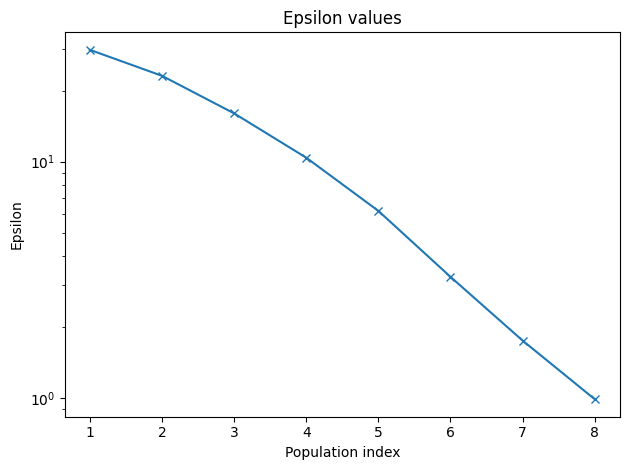

In [7]:
pyabc.visualization.plot_acceptance_rates_trajectory(history)
pyabc.visualization.plot_epsilons(history)

The posterior parameter distributions look similar to the ABC rejection example, but we have many more particles so they are smoother.

array([[<Axes: ylabel='A_11'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='A_12'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='A_21'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='A_22'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='r_1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='r_2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='y0_1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='A_11', ylabel='y0_2'>, <Axes: xlabel='A_12'>,
        <Axes: xlabel='A_21'>, <Axes: xlabel='A_22'>,
        <Axes: xlabel='r_1'>, <Axes: xlabel='r_2'>,
        <Axes: xlabel='y0_1'>, <Axes: xlabel='y0_2'>]], d

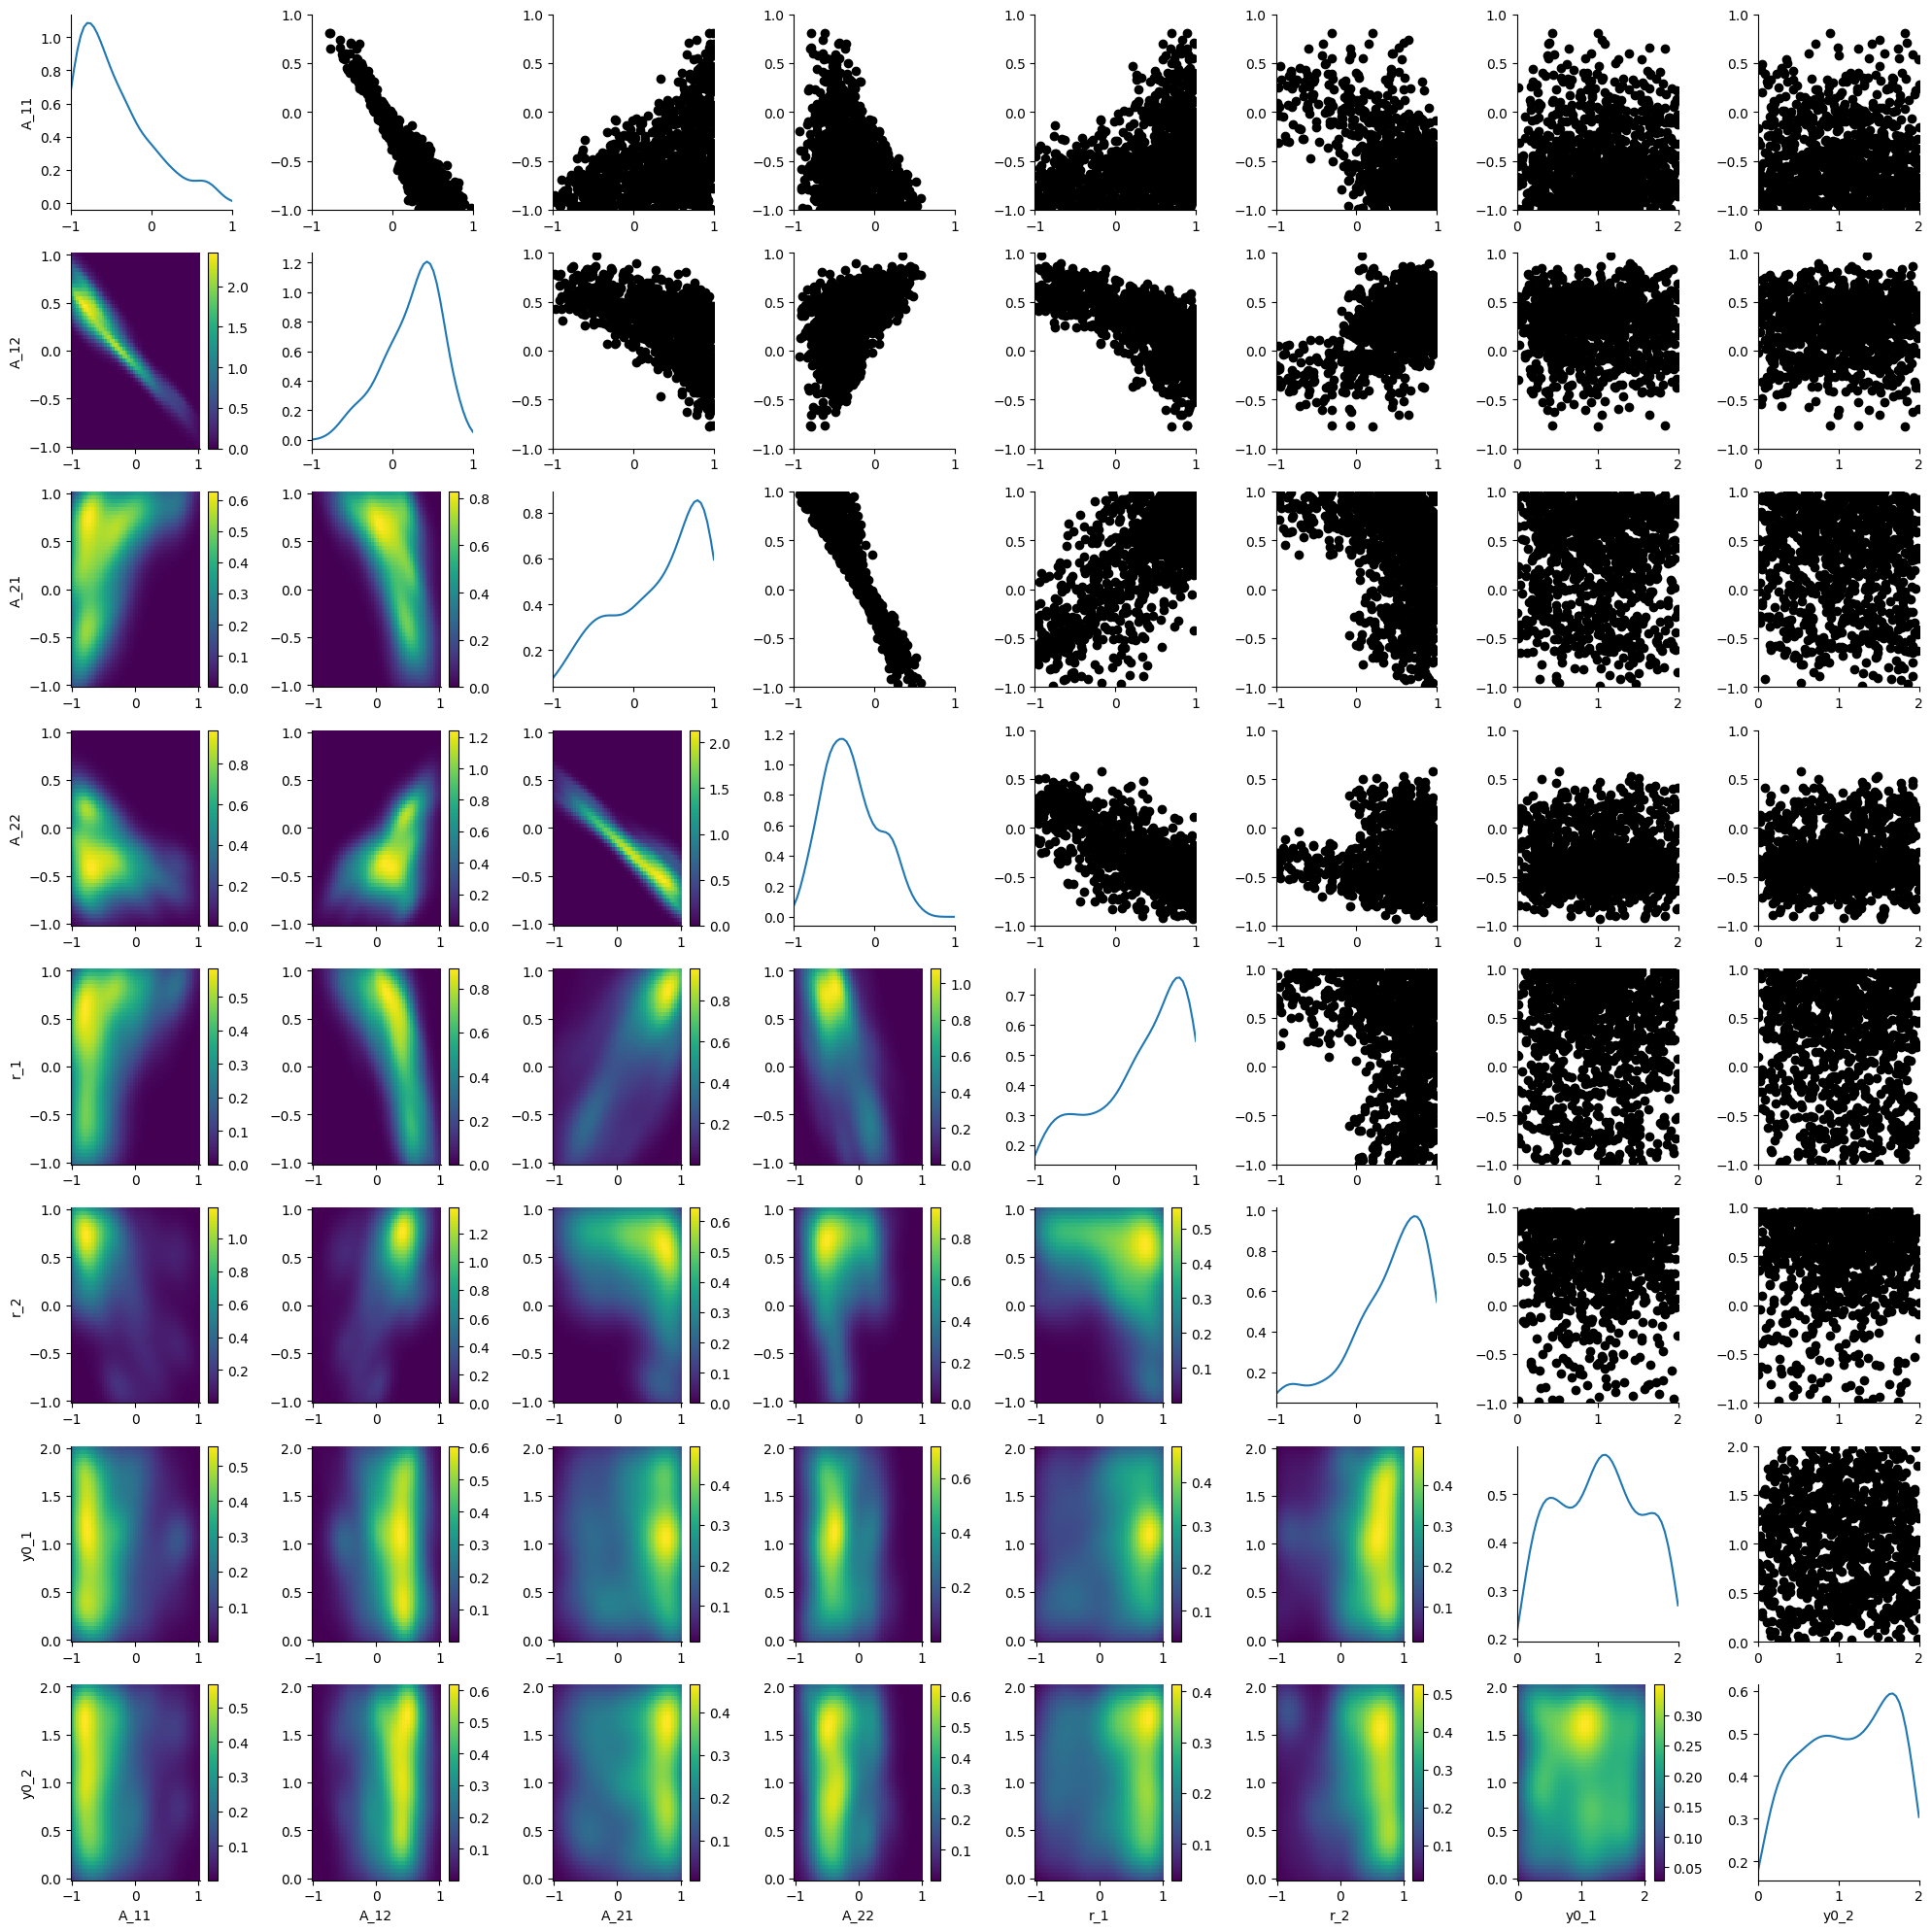

In [8]:
# get axes limits from priors for plotting
param_limits = {}
for key, dist in prior.items():
    loc, scale = dist.args
    param_limits[key] = (loc, loc + scale)

pyabc.visualization.plot_kde_matrix_highlevel(history, limits=param_limits)

And from the confidence intervals, you can see our trajectories are much closer to our objective.

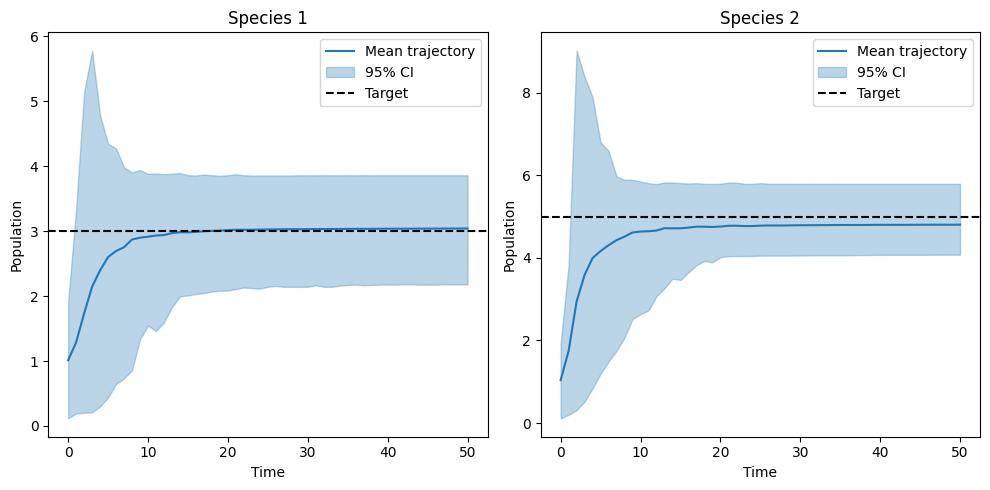

In [9]:
posteriors = history.get_population_extended()

all_trajectories = []
for particle_idx in range(posteriors.shape[0]):
    all_trajectories.append(posteriors.iloc[particle_idx]["sumstat_y"])

all_trajectories = np.array(all_trajectories)  # shape: (N, 2, T)
n_species = all_trajectories.shape[1]
t = np.linspace(0, 50, 51)

fig, axes = plt.subplots(1, n_species, figsize=(10, 5), sharex=True)

for i in range(n_species):
    species_traj = all_trajectories[:, i, :]  # shape: (N, T)
    mean_traj = np.mean(species_traj, axis=0)
    lower = np.percentile(species_traj, 2.5, axis=0)
    upper = np.percentile(species_traj, 97.5, axis=0)

    ax = axes[i] if n_species > 1 else axes
    ax.plot(t, mean_traj, color='C0', label='Mean trajectory')
    ax.fill_between(t, lower, upper, color='C0', alpha=0.3, label='95% CI')
    ax.set_title(f"Species {i+1}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Population")

    # Add target line if desired
    if i == 0:
        ax.axhline(3.0, color='k', linestyle='--', label='Target')
    elif i == 1:
        ax.axhline(5.0, color='k', linestyle='--', label='Target')

    ax.legend()

plt.tight_layout()
plt.show()

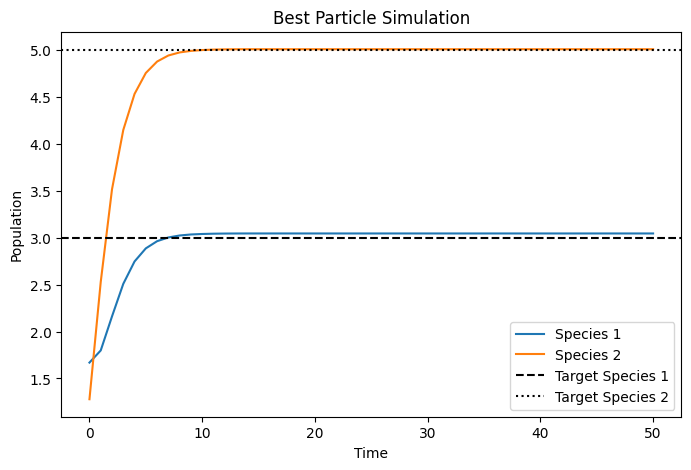

In [10]:
# simulate and plot best particle
best_particle = posteriors.loc[posteriors['distance'].idxmin()]
# extract parameters into a disctionary
params = {'A_11': best_particle['par_A_11'],
          'A_12': best_particle['par_A_12'], 
          'A_21': best_particle['par_A_21'], 
          'A_22': best_particle['par_A_22'],
          'y0_1': best_particle['par_y0_1'],
          'y0_2': best_particle['par_y0_2'],
          'r_1': best_particle['par_r_1'],
          'r_2': best_particle['par_r_2'],
          }
model = GLVModel(num_species=2, timepoints=simulation_timepoints)
result = model.simulate(params)  # simulate with the first accepted parameters
if result['success']:
    plt.figure(figsize=(8, 5))
    for i in range(result['y'].shape[0]):
        plt.plot(result['t'], result['y'][i, :], label=f'Species {i+1}')
    plt.axhline(3.0, color='k', linestyle='--', label='Target Species 1')
    plt.axhline(5.0, color='k', linestyle=':', label='Target Species 2')
    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.title('Best Particle Simulation')
    plt.legend()
    plt.show()
